In [1]:
from __future__ import division
import os
import numpy as np
import random 
import pandas as pd
import itertools
import subprocess
import imp
twto = imp.load_source('twto','/cellar/users/twang/scripts/twang_toolbox.py')
import scipy.stats as stats
import collections
#import fancyimpute

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline
sns.set(context='notebook',style='ticks')
meth = imp.load_source('meth','/cellar/users/twang/scripts/methylation_scripts/methy_parsing.py')

/cellar/users/twang/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#These scripts contain some basic functions I use, mainly for plotting predictions and fitting a ols to predicted and actual ages,
#You can use whatever you want to visualize the data.
modev = imp.load_source('modev','/cellar/users/twang/scripts/methylation_scripts/TrainModelScripts/evaluate_multiple_models_module.py')
from modev import *
testfuncs = imp.load_source('testfuncs','/cellar/users/twang/scripts/methylation_scripts/TrainModelScripts/enet_learn_test_plotting_fxns.py')
from testfuncs import *

## Age prediction Models

These are Andy's predict age functions

In [3]:
#Horvath's transfer age functions
def tranfer_fx(x, adult_age=20):
    x = np.float(x)
    x=(x+1)/(1+adult_age)
    y = np.log(x) if x <= 1 else x - 1
    return y
    

def anti_tranfer_fx(x, adult_age=20):
    if x < 0:
        return (1+adult_age)*np.exp(x)-1
    else:
        return (1+adult_age)*x+adult_age

In [4]:
#Function to use horvath's model
horvath_model_f = '/cellar/users/twang/dog_methylation/HorvathCoefficientsCpGModel.csv'
horvath_model = pd.read_table(horvath_model_f, sep=',', index_col=0)
                              #skiprows=[0,1])
horvath_intercept = horvath_model.CoefficientTraining['(Intercept)']
horvath_model = horvath_model.iloc[1:]

def run_horvath_model(df):
    '''
    Uses global variables horvath_model and horvath_intercept.  At some point I should
    move this to a class.
    
    Input data-frame should be normalized using Horvath's normalization script.
    '''
    #df = df.fillna(horvath_model.medianByCpG)
    df = df[horvath_model.CoefficientTraining.dropna().index]
    pred_age = df.dot(horvath_model.CoefficientTraining.dropna()) + horvath_intercept
    pred_age = pred_age.apply(anti_tranfer_fx)
    pred_age.name = 'predicted age (Horvath)'
    return pred_age

In [5]:
#Function to use hannum's model
hannum_model_f = '/cellar/users/twang/dog_methylation/Hannum_All.csv'
hannum_model = pd.read_csv(hannum_model_f,sep=',', index_col=0)

def run_hannum_model(df):
    df = df[hannum_model.Coefficient.index]
    pred_age = df.dot(hannum_model.Coefficient)
    pred_age.name = 'predicted age (Hannum)'
    return pred_age

## Loading data

In [73]:
#This HDF file has the combined Hannum and Epic datasets that andy used in his paper if you need them.
#The HDF files contains the following keys:
#'adj_betas':BMIQ+Quantile Normalized to median of Hannum dataset after adjusting for cell composition (identical to Andy's processing
#'cell_counts':the output of estimateCellCounts the minfi function
#'covariates':the covariates for the Fox Dataset
#'Other_Covariates':the covariates for hannum and epic datasets
#'study_index':the mapping index to studies
#'qn_betas':Quantile normalized betas before adjusting for cell composition
#'adj_qn_betas':Quantile normalized betas after adjusting for cell composition
#You can selectively pick only the foxDataset using 'Other_Covariates', 'covariates' or 'study_index' to figure out which index goes to what study
#for all datasets

outhdf = '/cellar/users/twang/Data/nrnb01_nobackup/human_methylation/Fox/files/ForTransfer/FoxHannumEpic_BMIQ_QuantNormed_AdjustedBetas.h5'
meth_mat = pd.read_hdf(outhdf,'adj_betas')
covariates_fox = pd.read_hdf(outhdf,'covariates')
covariates_he = pd.read_hdf(outhdf,'Other_Covariates')

In [6]:
covariatef_rp = '/cellar/users/twang/Data/nrnb01_nobackup/human_methylation/Fox/files/MethylomeResults.xlsx'
covariates_fox2 = pd.read_excel(covariatef_rp, header=0)

In [48]:
covariates_fox2.index = covariates_fox2['ID'].str.upper()
covariates_fox2.index = [x.replace('MAMMO','') for x in covariates_fox2.index]
covariates_fox2['PATID2'] = [x.replace('MAMMO','') for x in covariates_fox2['ID'].values]

In [52]:
keepinds = covariates_fox2.index.intersection(covariates_fox.index).unique()

In [55]:
mapagedf = covariates_fox2[['Age at Blood Draw (Exact)','PATID2']].drop_duplicates()

In [58]:
#mapagedf

In [47]:
print '\n'.join(['\t'.join(map(lambda x: str(x),x)) for x in mapagedf.loc['A022P'].values])

60.7166666667	A022P
54.0111111111	A022P


In [59]:
map_exact_age = {ind:mapagedf.loc[ind,'Age at Blood Draw (Exact)'] for ind in keepinds}

In [61]:
#map_exact_age

In [74]:
#Subsetting to only the Fox samples
#meth_mat = meth_mat.loc[covariates_fox.index]
meth_mat = meth_mat.loc[keepinds.intersection(meth_mat.index)]
covariates_fox.loc[meth_mat.index,'Age'] = [map_exact_age[ind] for ind in meth_mat.index]
covariates_fox.loc[meth_mat.index,'Status'] = [['C','P']['P' in x] for x in meth_mat.index]

In [63]:
#The output of the minfi uses the ID_Chip instead of the sample name, so I am making a mapping between them with all samples
outfcovars='/cellar/users/twang/Data/nrnb01_nobackup/human_methylation/children_methylation/data/HannumEpicGSE36054EMTAB4147_Covariates.csv'
covars = pd.read_csv(outfcovars,header=0,index_col=0)
map_names = {ind:covars.loc[ind,'Sample_Name'] for ind in covars.index}
map_names['F_BL'] = 'FX_BL'
for ind in covariates_fox.index:
    idchp = covariates_fox.loc[ind,'ID_Chip']
    map_names[idchp] = ind

## QC using detection p-value output of minfi

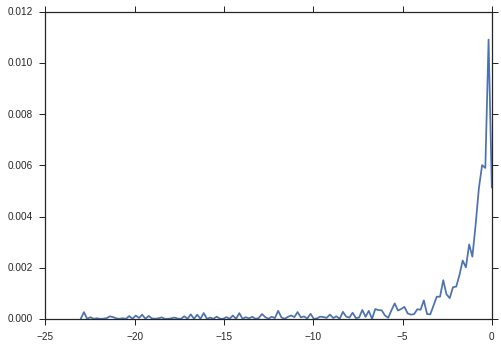

In [66]:
#Checking pvalue for the age sites
detection_p_mat = pd.read_csv('/cellar/users/twang/Data/nrnb01_nobackup/human_methylation/Fox/files/ForTransfer/FoxData_detectionPValues_192FoxSamples.csv',header=0,index_col=0,sep=',',engine='c')
detection_p_mat.columns = [map_names[x] for x in detection_p_mat.columns]
detection_p_mat_modelcpgs = detection_p_mat.loc[hannum_model.index.union(horvath_model.index)]
detection_p_mat_modelcpgs_clip = detection_p_mat_modelcpgs.clip_lower(1E-10) #Clipping the 0 values to 1E-10 so I can perform log transformation on the matrix
sns.kdeplot(detection_p_mat_modelcpgs_clip.apply(lambda x: np.log(x)).values.flatten())

In [67]:
detection_p_mat_modelcpgs_bool = (detection_p_mat_modelcpgs>1E-3)
exclude_samples = (detection_p_mat_modelcpgs_bool[detection_p_mat_modelcpgs_bool.columns[detection_p_mat_modelcpgs_bool.sum()>0]].sum())/detection_p_mat_modelcpgs_bool.shape[0]
exclude_samples

A075P    0.233945
A118P    0.949541
A105C    0.951835
dtype: float64

In [75]:
## Remove these samples that have a poor detection limit
inds_to_keep = meth_mat.index.difference(exclude_samples.index)
meth_mat_filt = meth_mat.loc[inds_to_keep]
covariates_fox_filt = covariates_fox.loc[inds_to_keep]

In [76]:
#Mark which samples were excluded in the covariates dataframe
covariates_fox.loc[exclude_samples.index,'Bad Detection at probes'] = 1
covariates_fox.loc[covariates_fox_filt.index,'Bad Detection at probes'] = 0

In [77]:
#Making sure that the samples got processed correctly
hannum_ages = run_hannum_model(meth_mat)
horvath_ages = run_horvath_model(meth_mat)
predicted_ages_consensus = pd.concat([hannum_ages, horvath_ages], axis = 1).mean(axis=1)
predicted_ages_consensus.isnull().sum()

0

## Get predicted ages for fox

Plot the individual age estimates

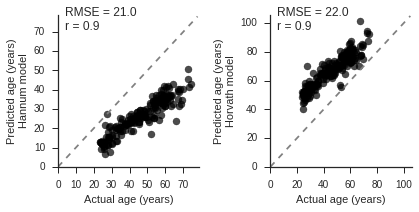

In [78]:
hannum_ages = run_hannum_model(meth_mat_filt)
horvath_ages = run_horvath_model(meth_mat_filt)
cc = sns.color_palette()
#i = 0
map_labels = ['Hannum','Horvath']
f,axes = plt.subplots(1,2,figsize=(6,3))
for i,predicted_ages in enumerate([ hannum_ages, horvath_ages]):
    ax = axes[i]
    j = 0
    modev.plot_model_values(ax,'Age',predicted_ages,covariates_fox_filt,abbrv=False,annot=True,color='black',s=50)
    ax.set_xlabel('Actual age (years)')
    ax.set_ylabel('Predicted age (years)\n{} model'.format(map_labels[i]))
    j=j+1
f.tight_layout()
sns.despine()
plt.show()
plt.close()

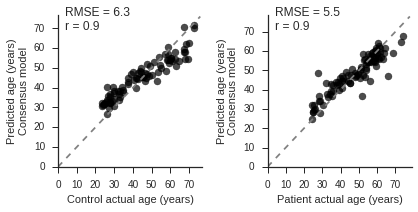

In [79]:
#plot the consensus age for each patient population
f,axes = plt.subplots(1,2,figsize=(6,3))
cc = sns.color_palette()
i=0
for k,grp in covariates_fox_filt.groupby('Status'):
    ax = axes[i]
    modev.plot_model_values(ax,'Age',predicted_ages_consensus,grp,abbrv=False,annot=True,color='black',s=50)
    ax.set_xlabel('{} actual age (years)'.format(['Control','Patient'][k=='P']))
    ax.set_ylabel('Predicted age (years)\n{} model'.format('Consensus'))
    i=i+1
sns.despine()
f.tight_layout()
plt.show()
plt.close()

In [80]:
#Rescale the ages of the models individually for each model
meth_ages_models = [ hannum_ages, horvath_ages]
inds2use_controls = covariates_fox_filt[covariates_fox_filt['Status']=='C'].index

linear_transform_ages_models_coefs = []
meth_ages_models_rescaled_controls = []

for meth_ages in meth_ages_models:
    m,b = make_lmreg(covariates_fox_filt.loc[inds2use_controls,'Age'],meth_ages.loc[inds2use_controls])
    linear_transform_ages_models_coefs.append((m,b))
    rescaled = (meth_ages - b)/ m
    meth_ages_models_rescaled_controls.append(rescaled)
#Get the consensus
predicted_age_consensus_rescaled = pd.concat(meth_ages_models_rescaled_controls,axis=1).mean(axis=1)

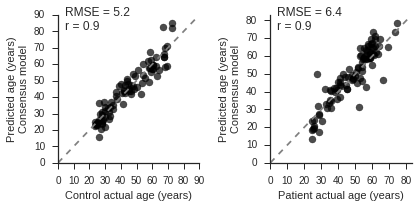

In [81]:
#plot the consensus age for each patient population
f,axes = plt.subplots(1,2,figsize=(6,3))
cc = sns.color_palette()
i=0
for k,grp in covariates_fox_filt.groupby('Status'):
    ax = axes[i]
    modev.plot_model_values(ax,'Age',predicted_age_consensus_rescaled.loc[grp.index],grp,abbrv=False,annot=True,color='black',s=50)
    ax.set_xlabel('{} actual age (years)'.format(['Control','Patient'][k=='P']))
    ax.set_ylabel('Predicted age (years)\n{} model'.format('Consensus'))
    i=i+1
sns.despine()
f.tight_layout()
plt.show()
plt.close()

In [82]:
#Save the output with the covariates file
covariates_fox.loc[predicted_age_consensus_rescaled.index,'Hannum predicted age'] = hannum_ages.loc[predicted_age_consensus_rescaled.index]
covariates_fox.loc[predicted_age_consensus_rescaled.index,'Horvath predicted age'] = horvath_ages.loc[predicted_age_consensus_rescaled.index]
covariates_fox.loc[predicted_age_consensus_rescaled.index,'Consensus predicted age'] = predicted_ages_consensus.loc[predicted_age_consensus_rescaled.index]
covariates_fox.loc[predicted_age_consensus_rescaled.index,'Hannum predicted age (adjusted)'] = meth_ages_models_rescaled_controls[0].loc[predicted_age_consensus_rescaled.index]
covariates_fox.loc[predicted_age_consensus_rescaled.index,'Horvath predicted age (adjusted)'] = meth_ages_models_rescaled_controls[1].loc[predicted_age_consensus_rescaled.index]
covariates_fox.loc[predicted_age_consensus_rescaled.index,'Consensus predicted age (adjusted)'] = predicted_age_consensus_rescaled
covariates_fox_filt = covariates_fox.loc[covariates_fox_filt.index]

In [83]:
#Get the age difference
agediff = (covariates_fox.loc[covariates_fox_filt.index,'Consensus predicted age (adjusted)']-covariates_fox.loc[covariates_fox_filt.index, 'Age'])
#Save to the covariates file
covariates_fox.loc[agediff.index,'Relative age advancement (consensus age adjusted)'] = covariates_fox_filt['Consensus predicted age (adjusted)']-covariates_fox_filt['Age at Visit 1 Date (years)']
covariates_fox_filt = covariates_fox.loc[covariates_fox_filt.index]

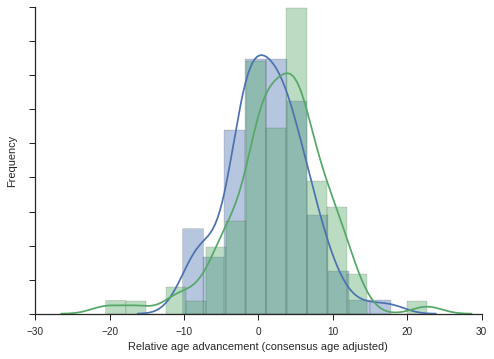

In [84]:
#Plot overall distribution
for k,grp in covariates_fox_filt.groupby('Status'):
    ax = sns.distplot(grp['Relative age advancement (consensus age adjusted)'].dropna(), label = k)
ax.set_xlabel('Relative age advancement (consensus age adjusted)')
ax.set_ylabel('Frequency')
ax.set_yticklabels([])
sns.despine()
plt.show()
plt.close()

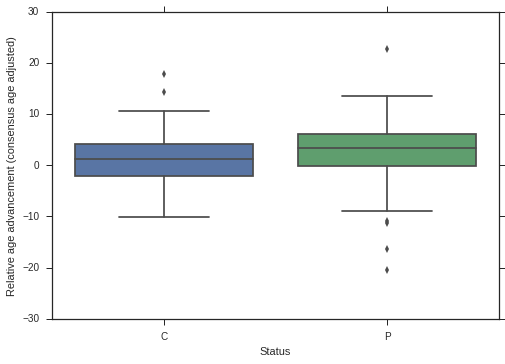

In [85]:
#Boxplot representation
sns.boxplot(x='Status', y = 'Relative age advancement (consensus age adjusted)', data = covariates_fox.loc[covariates_fox.index.difference(exclude_samples.index)])

In [86]:
#Calculate kruskal wallace p-value
stats.kruskal(*[grp['Relative age advancement (consensus age adjusted)'].dropna()
                for k,grp in covariates_fox_filt.groupby('Status')])

KruskalResult(statistic=5.3210808775069154, pvalue=0.021068938649502319)

In [87]:
#Description of the relative age advancement
pd.concat([grp['Relative age advancement (consensus age adjusted)'].dropna().describe()
                for k,grp in covariates_fox_filt.groupby('Status')],
          keys = [k for k,grp in covariates_fox_filt.groupby('Status')], axis = 1)

,C,P
count,86.000000,95.000000
mean,1.220575,2.695090
std,5.236976,6.374703
min,-10.185771,-20.519570
25%,-1.998960,-0.179462
50%,1.328526,3.307889
75%,4.259065,6.140722
max,17.789145,22.668062


In [88]:
#Write out covariates file to send to collaborators.
covariates_fox.to_csv('/cellar/users/twang/Data/nrnb01_nobackup/human_methylation/Fox/files/180620_FoxCovariates_with_age_predictions_ChangeAge2AgeAtBloodDraw.txt',
                     sep = '\t', header = True, index = True)

In [26]:
#covariates_fox